<a href="https://colab.research.google.com/github/AldairToSayH/Versi-n-para-RISIB-Reciclaje-Inteligente-/blob/main/RISIB-Reciclaje-Inteligente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Descargando dataset de basura...
Using Colab cache for faster access to the 'garbage-classification' dataset.
Dataset descargado en: /kaggle/input/garbage-classification
Cargando imágenes de entrenamiento...
Found 12415 images belonging to 12 classes.
Cargando imágenes de validación...
Found 3100 images belonging to 12 classes.
Clases detectadas para RISIB: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Iniciando entrenamiento del sistema RISIB...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 146s 361ms/step - accuracy: 0.4127 - loss: 1.8912 - val_accuracy: 0.5571 - val_loss: 1.3612
Epoch 2/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 105s 271ms/step - accuracy: 0.5734 - loss: 1.2801 - val_accuracy: 0.5842 - val_loss: 1.2217
Epoch 3/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 106s 273ms/step - accuracy: 0.6122 - loss: 1.1645 - val_accuracy: 0.6252 - val_loss: 1.1107
Epoch 4/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 106s 274ms/step - accuracy: 0.6420 - loss: 1.0797 - val_accuracy: 0.5997 - val_loss: 1.1325
Epoch 5/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 106s 272ms/step - accuracy: 0.6553 - loss: 1.0235 - val_accuracy: 0.6458 - val_loss: 1.0464
Epoch 6/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 105s 270ms/step - accuracy: 0.6699 - loss: 0.9869 - val_accuracy: 0.6223 - val_loss: 1.1041
Epoch 7/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 103s 265ms/step - accuracy: 0.6818 - loss: 0.9723 - val_accuracy: 0.6555 - val_loss: 1.0729
Epoch 8/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 105s 272ms/step - accuracy: 0.6923 -

¡Modelo RISIB entrenado! Sube una foto de basura (papel, plástico, vidrio, etc.) para probar:


Saving 2149056485.jpg to 2149056485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


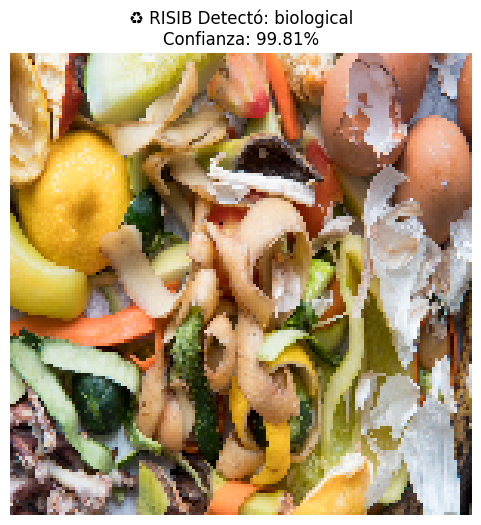

In [1]:
# En Google Colab - Versión para RISIB (Reciclaje Inteligente)
!pip install kagglehub -q
!pip install tensorflow -q

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
from google.colab import files
import cv2
import os

# Verificar si tenemos GPU
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

# 1. Descargar dataset de BASURA de Kaggle
print("Descargando dataset de basura...")
# Usamos un dataset popular de 12 clases de basura
path = kagglehub.dataset_download("mostafaabla/garbage-classification")
print(f"Dataset descargado en: {path}")

# Ajuste de ruta (este dataset suele tener una subcarpeta)
dataset_path = os.path.join(path, "garbage_classification")

# Configuración
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 30 # 30 es suficiente para probar rápido, sube a 50-100 para mejorar

# 2. Data generators (Aquí detectamos automáticamente las clases de basura)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

print("Cargando imágenes de entrenamiento...")
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # CAMBIO IMPORTANTE: Categorical para múltiples tipos de basura
    subset='training'
)

print("Cargando imágenes de validación...")
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Guardamos los nombres de las clases (ej: Papel, Plástico, Vidrio...)
class_names = list(train_generator.class_indices.keys())
print(f"Clases detectadas para RISIB: {class_names}")

# 3. Modelo CNN (Adaptado para múltiples clases)
model = keras.Sequential([
    keras.layers.Conv2D(32, 3, activation='relu', input_shape=(150, 150, 3)),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    # CAMBIO: La salida tiene tantas neuronas como tipos de basura y usa softmax
    keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy', # CAMBIO: Loss para múltiples clases
              metrics=['accuracy'])

# 4. Entrenar con GPU
print("Iniciando entrenamiento del sistema RISIB...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

# Guardar modelo
model.save('risib_garbage_model.h5')

# 5. Función para subir y predecir imágenes (Adaptada)
def upload_and_predict():
    """Sube una imagen y clasifica el tipo de basura"""
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Preprocesar imagen
        img = keras.preprocessing.image.load_img(filename, target_size=IMG_SIZE)
        img_array = keras.preprocessing.image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predecir
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0]) # Obtener probabilidades

        # Obtener el índice con mayor probabilidad
        predicted_class_index = np.argmax(predictions[0])
        predicted_label = class_names[predicted_class_index]
        confidence = np.max(predictions[0])

        # Mostrar resultado
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')

        plt.title(f'♻️ RISIB Detectó: {predicted_label}\nConfianza: {confidence:.2%}')
        plt.show()

# Probar con una imagen que subas
print("¡Modelo RISIB entrenado! Sube una foto de basura (papel, plástico, vidrio, etc.) para probar:")
upload_and_predict()

### Métricas de entrenamiento (KPIs)

Historial de entrenamiento (KPIs):


,accuracy,loss,val_accuracy,val_loss
0,0.483125,1.595168,0.557097,1.361198
1,0.584213,1.242297,0.584194,1.221697
2,0.620701,1.142665,0.625161,1.110689
3,0.641885,1.077872,0.599677,1.132458
4,0.660250,1.019402,0.645806,1.046377


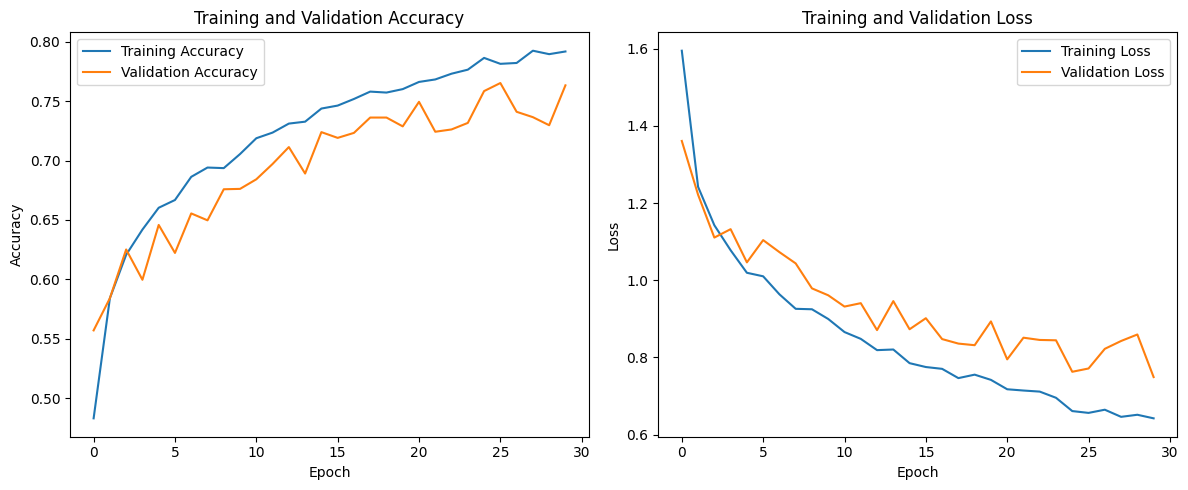

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir el historial de entrenamiento a un DataFrame para una mejor visualización
history_df = pd.DataFrame(history.history)

print("Historial de entrenamiento (KPIs):")
display(history_df.head())

# Opcional: Graficar el historial de entrenamiento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Probar el modelo RISIB con una nueva imagen

Ejecuta la siguiente celda para subir una nueva imagen y obtener su clasificación sin necesidad de re-entrenar el modelo.

Sube una foto de basura para que el modelo RISIB la clasifique:


Saving 1000_F_93320716_0ytpJQGzYyZyBtPwkh499fRc1IB9wnnn.jpg to 1000_F_93320716_0ytpJQGzYyZyBtPwkh499fRc1IB9wnnn.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


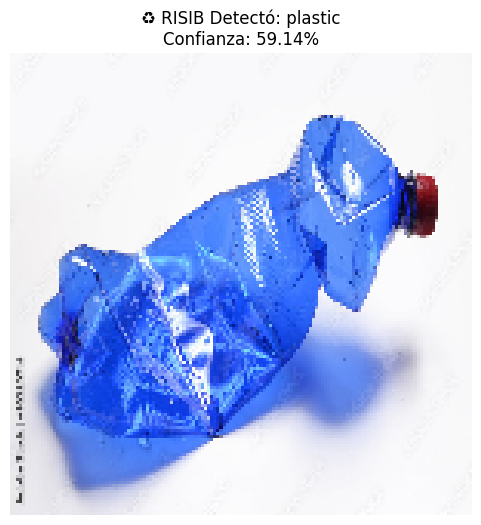

In [4]:
print("Sube una foto de basura para que el modelo RISIB la clasifique:")
upload_and_predict()